Drive mount

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


global variable init

In [1]:
pwd_folder = '/content/drive/MyDrive/Colab_Notebooks/VAE/'

Import package

In [2]:
import cv2, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from drive.MyDrive.Colab_Notebooks.VAE.model import Variatinal_Auto_Encoder, Auto_Encoder
from drive.MyDrive.Colab_Notebooks.VAE.utils import ELBO_loss

MINST data download

In [3]:
train_dataset = datasets.MNIST(root = pwd_folder + "MNIST_data/train",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor( ))

test_dataset = datasets.MNIST(root = pwd_folder + "MNIST_data/test",
                              train = False,
                              download = True,
                              transform = transforms.ToTensor( ))

Data Loader

In [4]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

Set hyper parameter(Variational Auto Encoder

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae_model = Variatinal_Auto_Encoder(device = device).to(device)
epoches = 60
lr = 1e-3
optimizer = optim.Adam(vae_model.parameters(), lr=lr)
Criterion = ELBO_loss

Train, Test

In [7]:
for epoch_i in range(epoches):
  '''----------------Train----------------'''
  vae_model.train()

  train_loss = 0.

  for x, _ in tqdm(train_loader, desc = 'Epoch {}/{}'.format(epoch_i+1, epoches)):
    # batchx1x28x28 -> batchx784
    x  = x.view(x.size()[0], -1).to(device)

    optimizer.zero_grad()
    x_reconst, (mean, stddev), _ = vae_model(x)
    loss, _ = Criterion(x_reconst, x, mean, stddev)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  train_loss /= len(train_loader)

  '''----------------Test----------------'''

  vae_model.eval()
  test_loss = 0.
  test_reconst_err = 0.
  test_KL_err = 0.

  with torch.no_grad():
    for x, _ in test_loader:
      x  = x.view(x.size()[0], -1).to(device)
      x_reconst, (mean, stddev), _ = vae_model(x)


      loss, (reconst_err, KL_err) = Criterion(x_reconst, x, mean, stddev)
      test_loss += loss.item()

      test_reconst_err += reconst_err.item()
      test_KL_err      += KL_err.item()

  test_loss /= len(test_loader)

  test_reconst_err /= len(test_loader)
  test_KL_err      /= len(test_loader)

  if (epoch_i+1) % 20 == 0:
    torch.save(vae_model.state_dict(), pwd_folder + 'weights/VAE_weight_epoch_{}.pt'.format((epoch_i+1)))
    print('Train loss = {:.4f}   Test loss = {:.4f}'.format(train_loss, test_loss))
    print('Test reconst_err, KL_err {:.4f}, {:.4f}'.format(test_reconst_err, test_KL_err))

Epoch 20/60: 100%|██████████| 469/469 [00:09<00:00, 50.47it/s]


Train loss = 167.7648   Test loss = 160.5604
Test reconst_err, KL_err 155.9981, 4.5623


Epoch 40/60: 100%|██████████| 469/469 [00:10<00:00, 43.81it/s]


Train loss = 166.3732   Test loss = 157.8256
Test reconst_err, KL_err 152.9134, 4.9122


Epoch 60/60: 100%|██████████| 469/469 [00:09<00:00, 50.76it/s]


Train loss = 165.3531   Test loss = 157.1905
Test reconst_err, KL_err 152.3436, 4.8469


Set hyper parameter(Auto Encoder)

In [6]:
ae_model = Auto_Encoder().to(device)
epoches = 60
lr = 1e-3
optimizer = optim.Adam(ae_model.parameters(), lr=lr)
Criterion = nn.BCELoss()

Train/Test

In [7]:
for epoch_i in range(epoches):
  '''----------------Train----------------'''
  ae_model.train()

  train_loss = 0.

  for x, _ in tqdm(train_loader, desc = 'Epoch {}/{}'.format(epoch_i+1, epoches)):
    x  = x.view(x.size()[0], -1).to(device)

    optimizer.zero_grad()
    x_reconst, _ = ae_model(x)
    loss = Criterion(x_reconst,x)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  train_loss /= len(train_loader)

  '''----------------Test----------------'''

  ae_model.eval()
  test_loss = 0.

  with torch.no_grad():
    for x, _ in test_loader:
      x  = x.view(x.size()[0], -1).to(device)
      x_reconst, _ = ae_model(x)


      loss = Criterion(x_reconst, x)
      test_loss += loss.item()

  test_loss /= len(test_loader)

  if (epoch_i+1) % 20 == 0:
    torch.save(ae_model.state_dict(), pwd_folder + 'weights/AE_weight_epoch_{}.pt'.format((epoch_i+1)))
    print('Train loss = {:.4f}   Test loss = {:.4f}'.format(train_loss, test_loss))

Epoch 20/60: 100%|██████████| 469/469 [00:08<00:00, 54.49it/s]


Train loss = 0.1994   Test loss = 0.1860


Epoch 40/60: 100%|██████████| 469/469 [00:08<00:00, 55.57it/s]


Train loss = 0.1972   Test loss = 0.1834


Epoch 60/60: 100%|██████████| 469/469 [00:08<00:00, 54.39it/s]


Train loss = 0.1961   Test loss = 0.1820


학습 가중치 저장 및 불러오기

In [40]:
epoch_i = 40

load_vae_model = Variatinal_Auto_Encoder(device = device)
load_vae_model.load_state_dict(torch.load(pwd_folder + 'weights/VAE_weight_epoch_{}.pt'.format(epoch_i)))
load_vae_model = load_vae_model.to(device)

load_ae_model = Auto_Encoder()
load_ae_model.load_state_dict(torch.load(pwd_folder + 'weights/AE_weight_epoch_{}.pt'.format(epoch_i)))
load_ae_model = load_ae_model.to(device)

class 별 Latent vector 확인(학습된 mean, stddev 에서 Sampling)

In [41]:
vae_z_dict = defaultdict(int)
ae_z_dict = defaultdict(int)

reconst_dict = defaultdict(int)

for class_i in range(10):
  idx = test_dataset.targets == class_i
  datset_class_i = test_dataset.data[idx][:400]

  load_vae_model.eval()
  load_ae_model.eval()
  with torch.no_grad():
    x = datset_class_i.view(datset_class_i.size()[0], -1)
    x = x.type(torch.FloatTensor)
    x = x.to(device)
    reconst_x, (_, _), z_vae = load_vae_model(x)
    _, z_ae = load_ae_model(x)

    reconst_img = reconst_x.view(reconst_x.size()[0], 28, 28)
    reconst_img = reconst_img.detach().to('cpu')
    reconst_dict['reconst_class_{}'.format(class_i)] = reconst_img

    z_vae = z_vae.detach().to('cpu')
    vae_z_dict['z_class_{}'.format(class_i)] = z_vae

    z_ae = z_ae.detach().to('cpu')
    ae_z_dict['z_class_{}'.format(class_i)] = z_ae

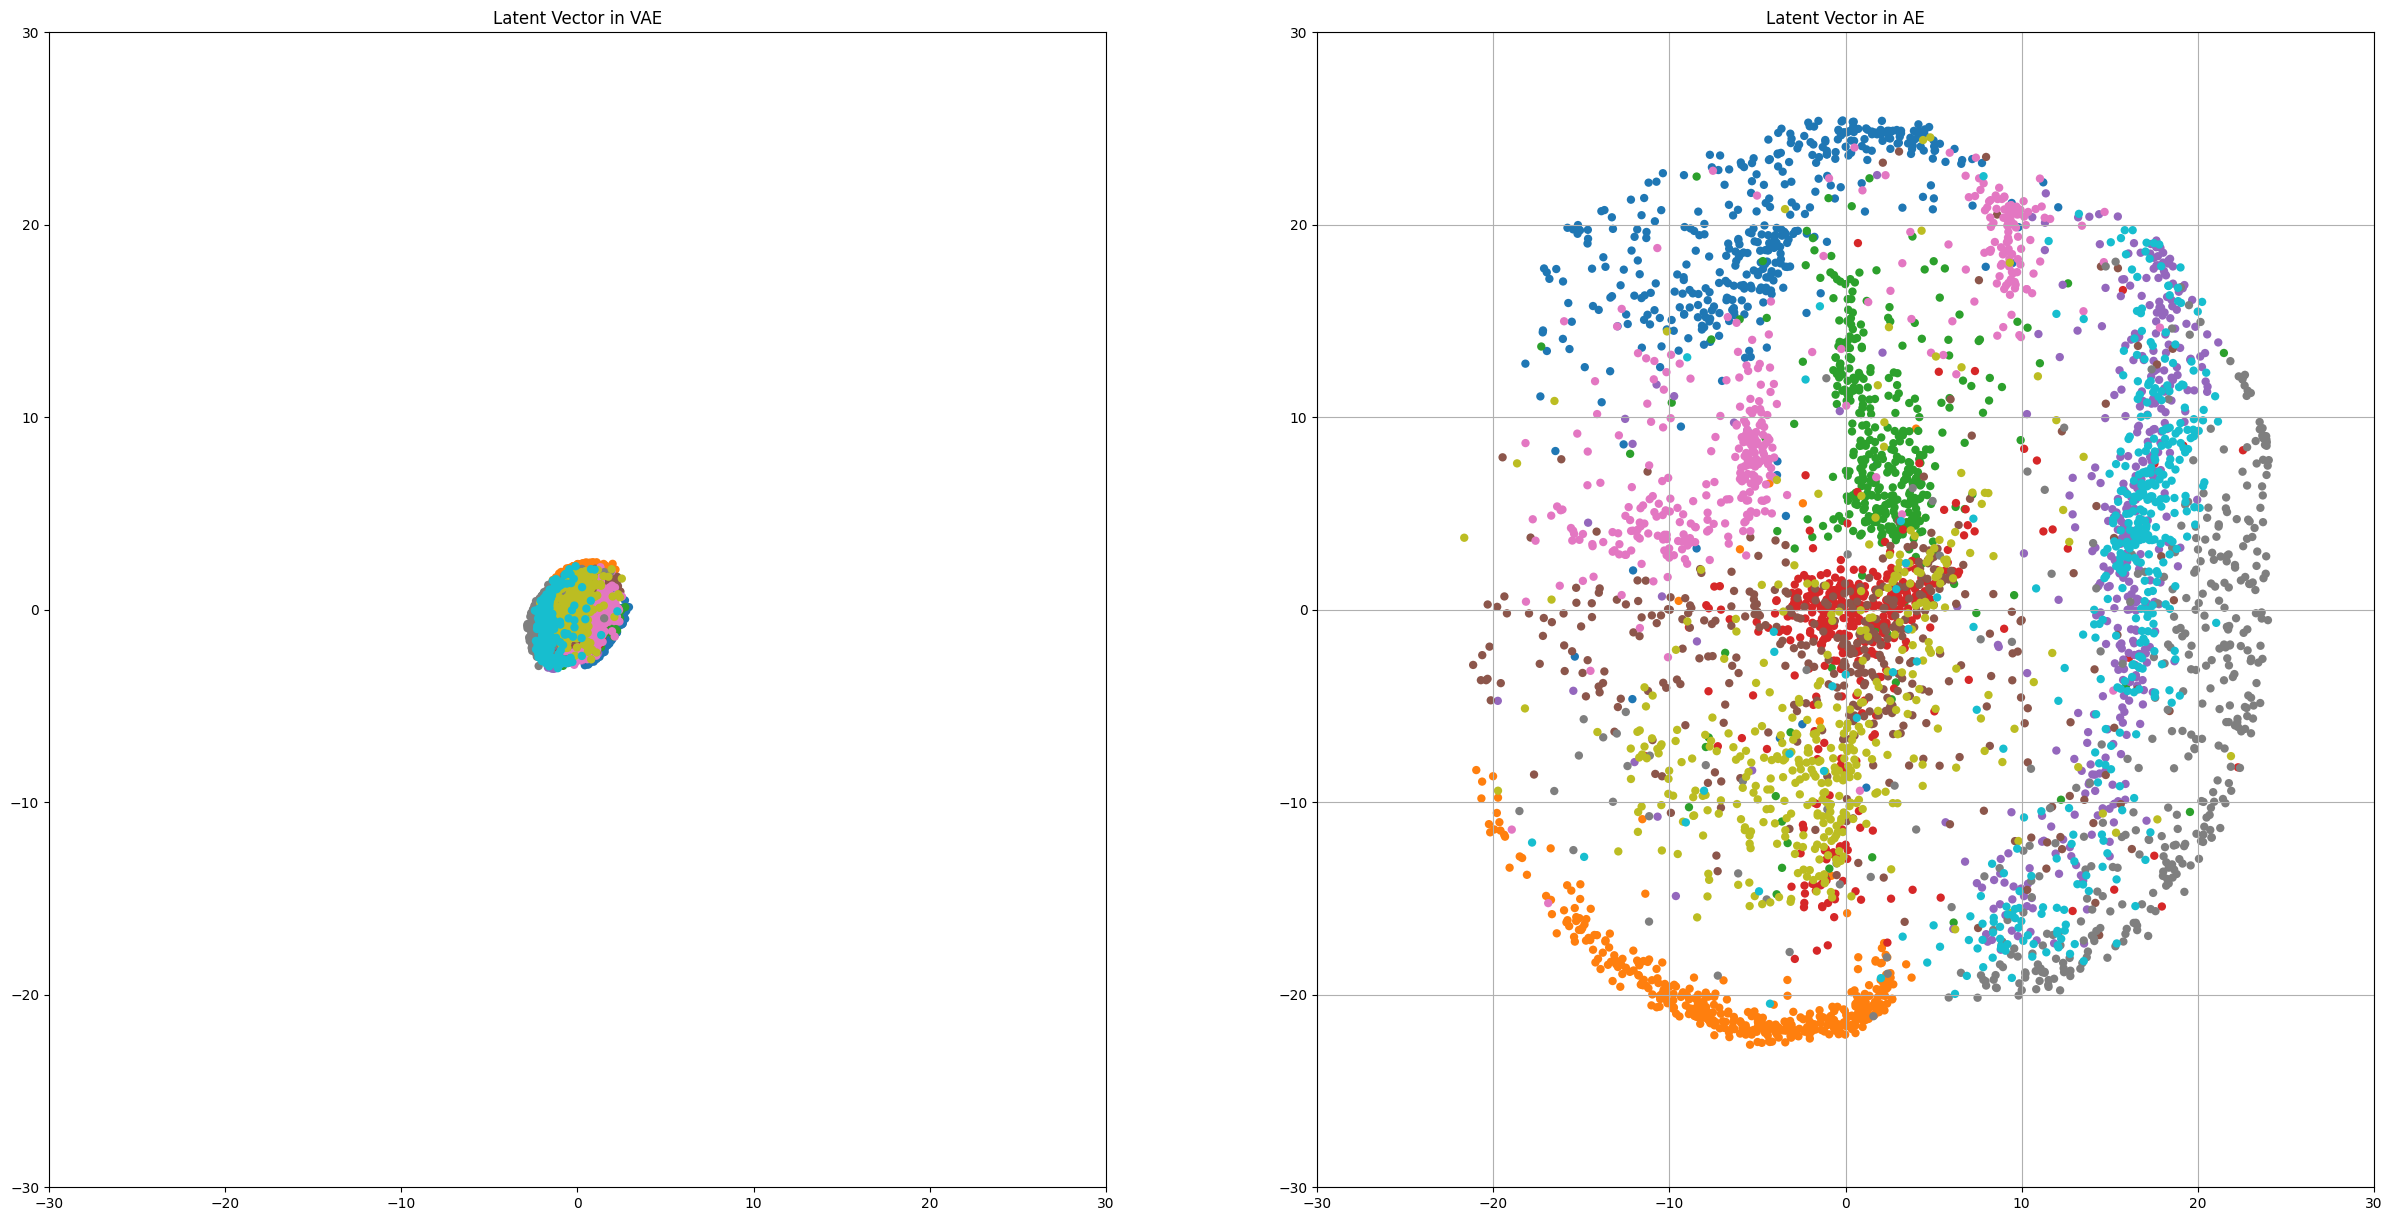

In [42]:
import matplotlib.colors as mcolors

color_list = mcolors.TABLEAU_COLORS

fig, ax = plt.subplots(1,2, figsize=(30, 15))
x, y, color = [], [], []

for class_i, z in enumerate(vae_z_dict.values()):
  x.append(z[:,0].tolist())
  y.append(z[:,1].tolist())
  color += [list(color_list.keys())[class_i]]*z.size()[0]

x, y, color = np.array(x), np.array(y), np.array(color)
x = x.reshape(-1)
y = y.reshape(-1)
color = color.reshape(-1)
ax[0].set_title('Latent Vector in VAE')
ax[0].scatter(x, y, c=color, marker='o', edgecolor='none')
ax[0].set_xlim([-30, 30])
ax[0].set_ylim([-30, 30])
plt.grid(True)

x, y, color = [], [], []

for class_i, z in enumerate(ae_z_dict.values()):
  x.append(z[:,0].tolist())
  y.append(z[:,1].tolist())
  color += [list(color_list.keys())[class_i]]*z.size()[0]

x, y, color = np.array(x), np.array(y), np.array(color)
x = x.reshape(-1)
y = y.reshape(-1)
color = color.reshape(-1)
ax[1].set_title('Latent Vector in AE')
ax[1].scatter(x, y, c=color, marker='o', edgecolor='none')
ax[1].set_xlim([-30, 30])
ax[1].set_ylim([-30, 30])
plt.grid(True)

fig.savefig(pwd_folder + 'result/figure_{}epoch.png'.format(epoch_i))

z 값에 변화에 따른 reconstruction img

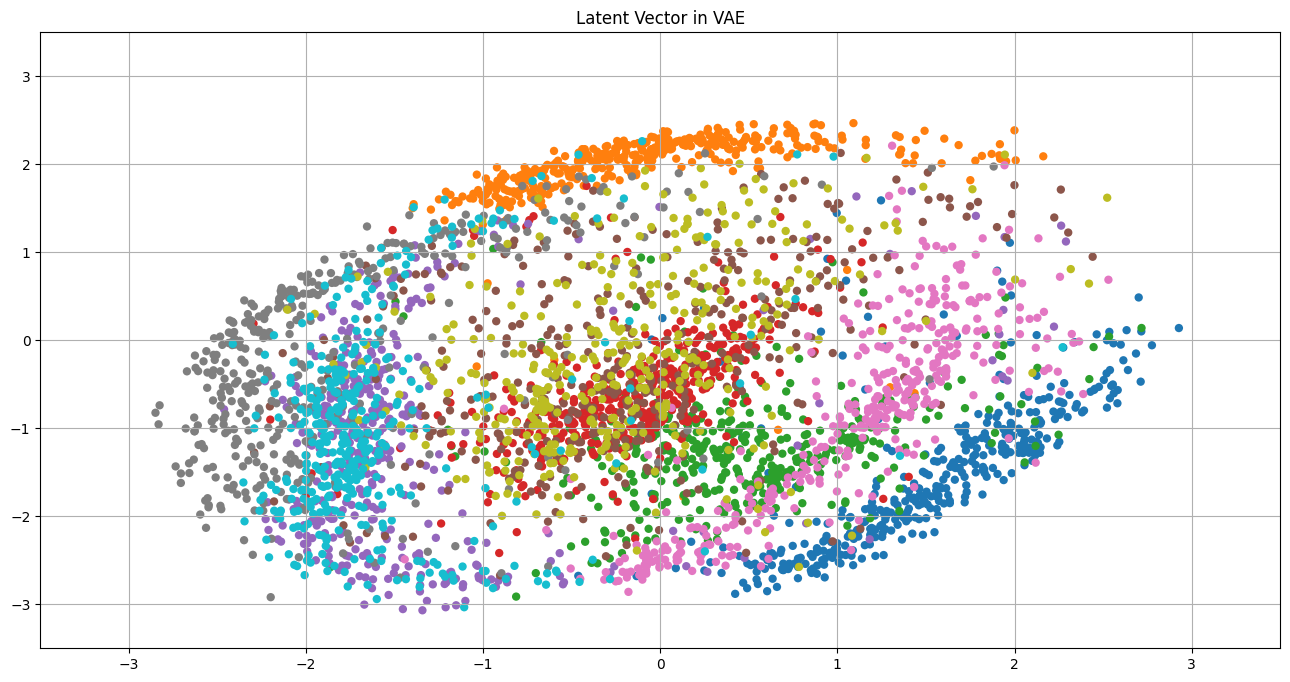

In [45]:
import matplotlib.colors as mcolors

color_list = mcolors.TABLEAU_COLORS

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
x, y, color = [], [], []

for class_i, z in enumerate(vae_z_dict.values()):
  x.append(z[:,0].tolist())
  y.append(z[:,1].tolist())
  color += [list(color_list.keys())[class_i]]*z.size()[0]

x, y, color = np.array(x), np.array(y), np.array(color)
x = x.reshape(-1)
y = y.reshape(-1)
color = color.reshape(-1)
ax.set_title('Latent Vector in VAE')
ax.scatter(x, y, c=color, marker='o', edgecolor='none')
ax.set_xlim([-3.5, 3.5])
ax.set_ylim([-3.5, 3.5])
plt.grid(True)

In [63]:
x = np.arange(-2.5, 2.5 + 0.25, 0.25)
y = np.arange(-2.5, 2.5 + 0.25, 0.25)
test_z = []

for x_ in x:
  for y_ in y:
    test_z.append([x_, y_])

test_z = np.array(test_z)

In [64]:
load_vae_model.eval()

with torch.no_grad():
  test_z = torch.FloatTensor(test_z).to(device)
  reconst_x = load_vae_model.decoder(test_z)
  reconst_img = reconst_x.view(reconst_x.size()[0], 28, 28)
  reconst_img = reconst_img.detach().to('cpu')

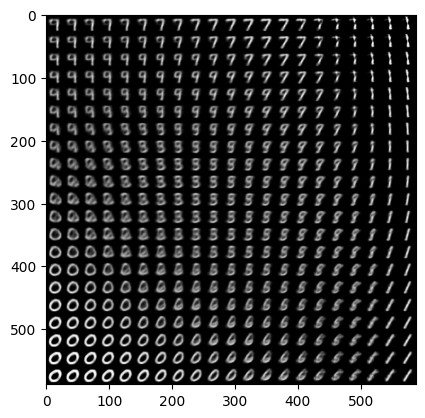

In [68]:
map_img = torch.ones(28*21, 28*21)

i = 0
for r in range(21):
  for c in range(21):
    map_img[r*28:r*28+28, c*28:c*28+28] = reconst_img[i]
    i += 1
save_folder = pwd_folder+'result/'

map_img = np.array(map_img*255).astype(np.uint8)
map_img_bgr = cv2.cvtColor(map_img, cv2.COLOR_GRAY2BGR)
cv2.imwrite(save_folder+'z_map.jpg', map_img_bgr)

plt.imshow(map_img, cmap='gray')

Save reconstruction img

In [69]:
for class_i in list(reconst_dict.keys()):
  imgs = reconst_dict[class_i][:10]
  save_folder = pwd_folder+'result/reconst_imgs/'+class_i.split('reconst_')[-1]+'/'

  if not os.path.exists(save_folder):
    os.makedirs(save_folder)

  for idx, img in enumerate(imgs):
    img = np.array(img*255).astype(np.uint8)
    bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.imwrite(save_folder+'img_{}.jpg'.format(idx), bgr)